<a href="https://colab.research.google.com/github/CompPsychology/psych290_colab_public/blob/main/notebooks/week-08/W8_Tutorial_13_Reddit_Scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W8 Tutorial 13 -- Reddit Scraper (2025-05)

✋🏻✋🏻 NOTE - You need to create a copy of this notebook before you work through it. Click on "Save a copy in Drive" option in the File menu, and safe it to your Google Drive.

✉️🐞 If you find a bug/something doesn't work, please slack us a screenshot, or email johannes.courses@gmail.com.

(c) Johannes Eichstaedt & the World Well-Being Project, 2023.


This tutorial walks through the steps to scrape a particular subreddit using a in-house Reddit scraper implemented using `Python`. Current scraper extracts the posts (also comments if needed) from a subreddit and writes them as a message table into your project databases named `reddit`.

## 1) Setting up Colab with DLATK and SQLite

### Install DLATK

In [ ]:
# installing DLATK and necessary packages
!git clone -b psych290 https://github.com/dlatk/dlatk.git
!pip install -r dlatk/install/requirements.txt
!pip install dlatk/
!pip install wordcloud langid jupysql praw gensim==4.3

### Setup database connection

In [ ]:
database='reddit'

In [ ]:
# loads the %%sql extension
%load_ext sql

# connects the extension to the database - mounts both databases as engines
from sqlalchemy import create_engine
tutorial_db_engine = create_engine(f"sqlite:///sqlite_data/{database}.db?charset=utf8mb4")
dlatk_lexica_engine = create_engine(f"sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4")

# attaches the dlatk_lexica.db so tutorial_db_engine can query both databases
from IPython import get_ipython
from sqlalchemy import event

# auto‑attach the lexica db whenever tutorial_db_engine connects
@event.listens_for(tutorial_db_engine, "connect")
def _attach_lexica(dbapi_conn, connection_record):
    dbapi_conn.execute("ATTACH DATABASE 'sqlite_data/dlatk_lexica.db' AS dlatk_lexica;")

%sql tutorial_db_engine

#set the output limit to 50
%config SqlMagic.displaylimit = 50

## Creating a Reddit application, and authentication

Before we use the APIs for scraping, we need to have a Reddit account. You can sign up here - https://www.reddit.com/register/.

Once you have a Reddit account, you need to create a Reddit application to access the APIs. This gives us the necessary parameters (mentioned below) required for authentication. You can create a new application here - https://old.reddit.com/prefs/apps/.

**Note:** Type of application is `script` and the redirect url is `http://localhost:8080`.

Below is the snapshot of an application that we created.

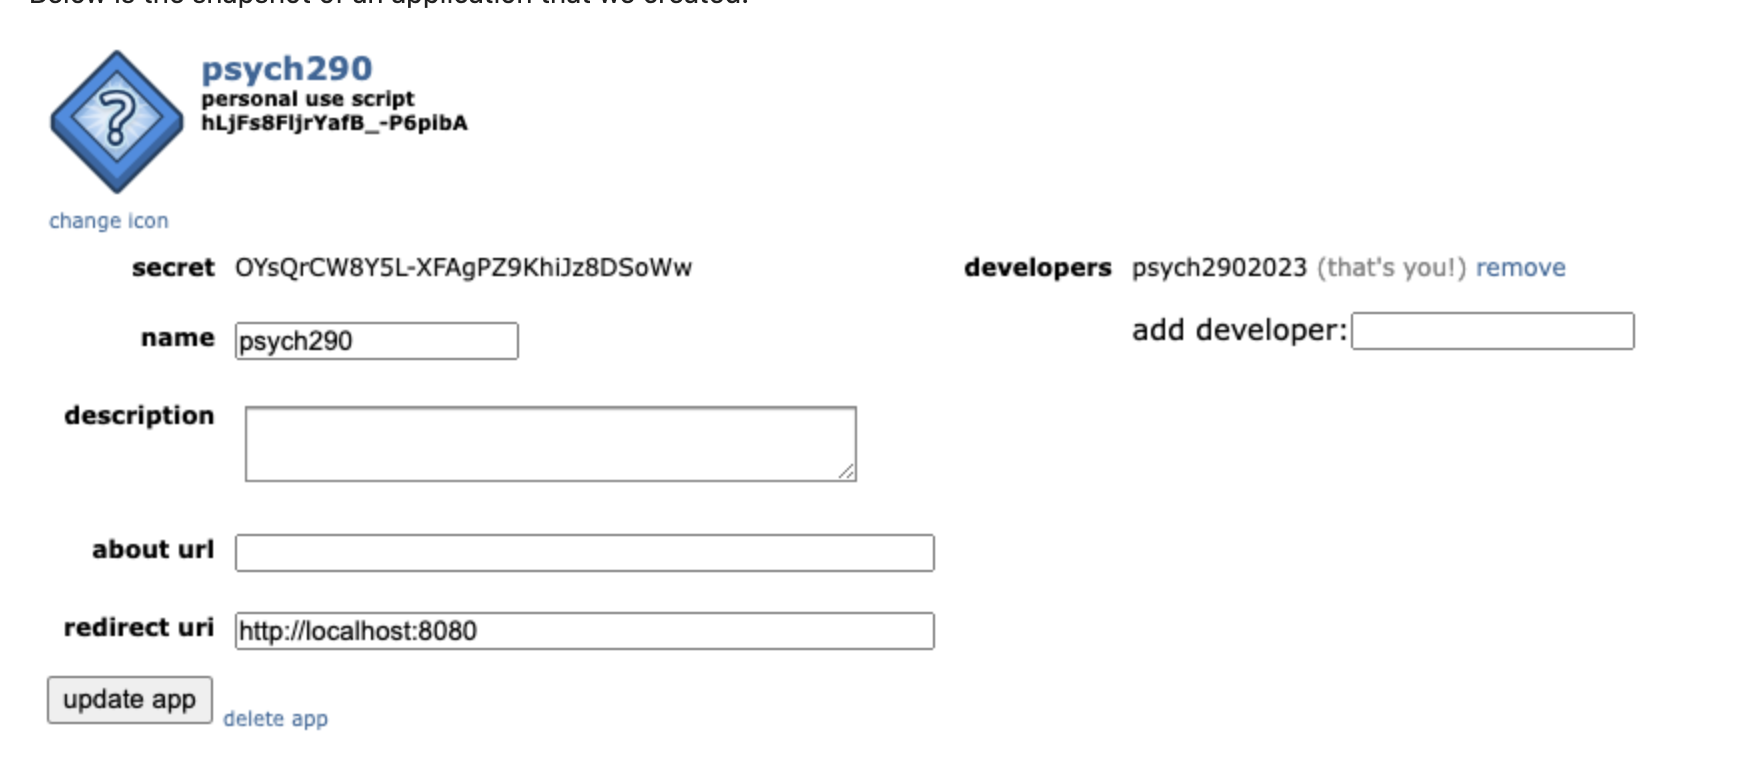

* **`CLIENT_ID`** - at least 14-character string listed just under “personal use script". In this case it's `hLjFs8FljrYafB_-P6pibA`
* **`CLIENT_SECRET`** -  at least a 27-character string listed adjacent to "secret". In this case, `OYsQrCW8Y5L-XFAgPZ9KhiJz8DSoWw`.
* **`PASSWORD`** - password for the Reddit account used to register the application.
* **`USERNAME`** - username of the Reddit account used to register the application. Here, the account is `psych2902023`.
* **`USER_AGENT`** - description of the app

You will store these parameters in the variables below. Same as how you do with `database` variable.

🚨 Please Slack us if you would like to use this, and we will send you the parameters below. ⬇️

In [ ]:
CLIENT_ID = ""
CLIENT_SECRET = ""
PASSWORD = ""
USER_AGENT = ""
USERNAME = ""

## Configuration

Now that we are connected to the database and have created a Reddit app, we need to configure our scraper to use the right database and Reddit app parameters. We do this by bundling the required configuration parameters into one container named `config`.

In [ ]:
from dataclasses import dataclass

@dataclass
class Config:

    username: str
    password: str
    client_id: str
    client_secret: str
    user_agent: str

    database:str = None
    table:str = None

The configuration container takes in the following parameters, in addition to the auth parameters assigned above:

* **`DATABASE`** - Your project database which is `reddit`
* **`TABLE`** - The SQL table (that contains scraped data) name, which is generated automatically, unless you prefer to override here.

In [ ]:
DATABASE = 'reddit'
TABLE = None # it makes a custom name below, only change if needed/wanted

config = Config(
    username = USERNAME,
    password = PASSWORD,
    client_id = CLIENT_ID,
    client_secret = CLIENT_SECRET,
    user_agent = USER_AGENT,
    database=DATABASE,
    table=TABLE)

## Setting up the scraping code

With the configuration set up, now we get into the meat of the tutorial, i.e, scraping from a subreddit.

To give you some context, we extract the data using [PRAW (Python Reddit API Wrapper)](https://github.com/praw-dev/praw) API which, like the name says, is a wrapper around the official APIs provided by Reddit.

The cell below implements the entire scraper in `Python`, which does this for you. The scraper extracts the posts and comments along with their meta-data like ID, Reddit username that posted it, date-time that it was created, etc.

### ⚠️ DISCLAIMER - Unfortunately, Reddit provides a maximum of 1000 posts at the moment.

If there is some additional meta-data we've missed, please let us know.*

In [ ]:
import praw
import pandas as pd
import sqlalchemy
import time

class RedditScraper:

    def __init__(self, config):

        self.api = praw.Reddit(
            client_id=config.client_id,
            client_secret=config.client_secret,
            password=config.password,
            user_agent=config.user_agent,
            username=config.username)

        # self.engine = sqlalchemy.create_engine(f'mysql://{config.mysql_user}@localhost/{config.database}?charset=utf8mb4')
        self.engine = sqlalchemy.create_engine(f'sqlite:///sqlite_data/{config.database}.db?charset=utf8mb4')


    def get_table_name(self, subreddit_name, keyword, num_posts, include_comments):

        table_name = 'rd'
        table_name += f'_{subreddit_name}' if subreddit_name is not None else ''

        if keyword is not None:
            keyword = keyword.replace(' ', '_')
            table_name += f'_W{keyword}'

        table_name += f'_{num_posts}' if num_posts is not None else '_all'
        table_name += '_wc' if include_comments else ''

        return table_name

    def scrape(self, subreddit_name=None, keyword=None, num_posts=None, include_comments=True):

        start_time = time.time()

        data = {'message_id': [],
                'author': [],
                'post_title': [],
                'post_content': [],
                'created_time': [],
                'message': [],
                'upvotes': [],
                'upvote_ratio': [],
                'is_post': [],
                'parent_post': []}

        table_name = self.get_table_name(subreddit_name, keyword, num_posts, include_comments)

        assert ((subreddit_name is not None) or (keyword is not None)), "Provide either Subreddit name or keyword :)"

        if subreddit_name is None: posts = self.api.subreddit('all').search(keyword, limit=num_posts)
        else: posts = self.api.subreddit(subreddit_name).top(limit=num_posts)

        for number, post in enumerate(posts):

            # data['author'].append(post.author)
            data['author'].append(str(post.author) if post.author else None)
            data['message_id'].append(post.id)
            data['post_title'].append(post.title)

            if post.selftext != '':
                data['post_content'].append(post.selftext)
                data['message'].append(post.title + ' ' + post.selftext)
            else:
                data['post_content'].append(None)
                data['message'].append(post.title)

            data['created_time'].append(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(post.created_utc)))
            data['upvotes'].append(post.score)
            data['upvote_ratio'].append(post.upvote_ratio)
            data['parent_post'].append(None)
            data['is_post'].append(1)

            if include_comments:

                post.comments.replace_more(limit=None)
                for comment in post.comments.list():

                    # data['author'].append(comment.author)
                    data['author'].append(str(post.author) if post.author else None)
                    data['message_id'].append(comment.id)
                    data['post_title'].append(None)
                    data['post_content'].append(comment.body)
                    data['message'].append(comment.body)
                    data['created_time'].append(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(comment.created_utc)))
                    data['upvotes'].append(comment.score)
                    data['upvote_ratio'].append(None)
                    data['parent_post'].append(post.id)
                    data['is_post'].append(0)

            if ((number + 1) % 10) == 0:
                print('{} posts scraped out of {}'.format(number+1, num_posts))

        data = pd.DataFrame(data)
        data.to_csv(table_name + '.csv', index=False) # Backup
        data.to_sql(table_name, self.engine, if_exists='replace', index=False)

        end_time = time.time()
        print('Scraped data saved in the table named {}'.format(table_name))
        print('Scraper terminated in {} seconds. A good day indeed!!'.format(end_time - start_time))

        return table_name

## The actual scraping

The scraper function, conveniently named `scrape` takes in the following parameters. This is similar to the switches that you pass to DLATK.

* **`SUBREDDIT`** - **[OPTIONAL]** name of the subreddit which you want to scrape.
* **`KEYWORD`** - **[OPTIONAL]** returns only posts/comments that contain this keyword. Default: `None`

**Note:** One of either `SUBREDDIT` or `KEYWORD` should be provided, both cannot be `None` at the same time.

* **`NUM_POSTS`** - total number of original posts that you want to scrape (+ their comments, if you set the below). When set to `None` then it means to fetch as many entries as possible.
* **`INCLUDE_COMMENTS`** - this switch if set to True (or False) extracts the comments from a post (or not)

Timing: the scraper can take from a few minutes to many hours depending on the popularity of the subreddit (thus more/less data) and the number of posts/comments you intend to extract. Best to start with 100, and see how long it takes, and inspect the data you get. Prototype and iterate, as with all things in life.

In [ ]:
SUBREDDIT = 'ocd'
KEYWORD = None # Default None
# only pull posts with a keyword e.g., KEYWORD = "diagnosis" or some combo of keywords e.g., "diagnosis OR diagnosed"
NUM_POSTS = None # this is the maximum of posts to pull.
# if you pick a high number (e.g., 10000), subreddit may yield fewer posts, because
# either there are simply aren't enough posts
# or because Reddit returns the most recent 1000 posts.
INCLUDE_COMMENTS = False

In [ ]:
scraper = RedditScraper(config)
table_name = scraper.scrape(SUBREDDIT, KEYWORD, NUM_POSTS, INCLUDE_COMMENTS)

## Explore and clean the scraped data

Now, let's begin the exploration by checking the columns of the saved table. The above cell generated a table, see the end of the output for its name. It will be something like `rd_ocd_all`.

This table_name has been passed on as a variable, which we load below into the message_table variable, to work with it in SQL.

In [ ]:
## setting SQL variables to inspect your output.
database = config.database
message_table = 'rd_ocd_all'

Reading out the variable:

In [ ]:
message_table

Let's see how many messages we pulled:

In [ ]:
%%sql

SELECT COUNT(*) from {{message_table}};

As a reminder, as an orientation, you need 50-100 per topic you want to model. So if we have 1,000 messages, we could model 10-20 topics.

Let's do some SQL housekeeping first though, and inspect the message table:

In [ ]:
%sql PRAGMA table_info({{message_table}});

FYI, we made an executive decision for you: we combined the title of the posts (`post_title`) and their content (`post_content`) into the `message` field. If you wish, you could pull title or content into separate message tables, shortlist down to one of those, filter down to titles that contain a keyword -- whatever your science requires.

Now, let's check if it did extract `NUM_POSTS` posts here. We can make use of `is_post` column for this. These are the original posts.

In [ ]:
%%sql

SELECT SUM(is_post) AS num_posts
FROM {{message_table}};

Okay, even that looks alright. Finally, let's print some random records.

In [ ]:
%%sql

SELECT *
FROM {{message_table}}
where is_post = 1
ORDER BY RANDOM()
LIMIT 5;

And finally before we close of this tutorial, let's clean the table. Reddit usually contains posts/comments that say `[removed]` which are either removed by the authors or moderated by subreddit moderators. Since, such posts don't contain any language data, let's delete them from the table.

In [ ]:
%%sql

DELETE
FROM {{message_table}}
WHERE message LIKE '%[removed]%';

You see how many were removed -- and let's see how many are left.

In [ ]:
%%sql

SELECT COUNT(*) FROM {{message_table}};

And that's it! From here on you should be able to ingest the message table for topic modeling, LIWC extraction, and so forth.

## Create a sample outcome table

As a friendly reminder, if you wish to correlate message content against upvotes (`--correl_field message_id`) to say find  the topics that were upvoted the most (`--correlate`), you need to make yourself an outcome table that contains `message_id` and `upvotes`.

For completeness, let's create an outcome table with all meta-data here.

In [ ]:
database = config.database
outcome_table = 'outcomes_' + message_table

In [ ]:
%%sql

DROP TABLE IF EXISTS {{outcome_table}};

CREATE TABLE {{outcome_table}} (message_id VARCHAR(50),
                                upvotes BIGINT(20),
                                author VARCHAR(50),
                                created_time DATETIME,
                                upvote_ratio DOUBLE,
                                is_post BIGINT(20),
                                PRIMARY KEY (message_id));

INSERT INTO {{outcome_table}} SELECT message_id, upvotes, author, created_time, upvote_ratio, is_post
                               FROM {{message_table}};

And, that gives you the outcome table as shown below.

In [ ]:
%sql  PRAGMA table_info({{outcome_table}});

In [ ]:
%%sql

SELECT *
FROM {{outcome_table}}
ORDER BY RANDOM()
LIMIT 5;

And a final reminder of your message table and outcome table names for further processing:

In [ ]:
message_table

In [ ]:
outcome_table

## Topic Modeling

First, 1-gram feature extraction!

In [ ]:
database = 'reddit'
msgs_table = 'rd_ocd_all'

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field message_id \
    --add_ngrams -n 1

Let's inspect stopwords.

In [ ]:
feat_1gram_user = 'feat$1gram$rd_ocd_all$message_id'
N = 100

In [ ]:
# set the output limit to 100
%config SqlMagic.displaylimit = 100

In [ ]:
%%sql

SELECT ROW_NUMBER() OVER (ORDER BY n_occ DESC) AS n, feat, n_occ
FROM (SELECT feat, SUM(value) AS n_occ
      FROM {{feat_1gram_user}}
      GROUP BY feat
      ORDER BY n_occ DESC
      LIMIT {{N}}) AS a;

```
🐬🐬🐬
SET @n = 0;
SELECT @n := @n + 1 n, a.*
FROM (SELECT feat, SUM(value) AS n_occ
      FROM {feat_1gram_user}
      GROUP BY feat
      ORDER BY n_occ DESC
      LIMIT {N}) AS a;
🐬🐬🐬
```

Now let's do topic modeling!

In [ ]:
database = 'reddit'
msgs_table = 'rd_ocd_all'
feat_1gram_user = 'feat$1gram$rd_ocd_all$message_id'

num_stopwords = 100
num_topics = 20
alpha = 2

lexicon_database = 'reddit'
lexicon_name = f'{msgs_table}_{num_topics}_a{alpha}_s{num_stopwords}'

OUTPUT_FOLDER = './output_tutorial_13/rd_ocd_all'
!mkdir -p {OUTPUT_FOLDER}

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field message_id \
    --feat_table '{feat_1gram_user}' \
    --estimate_lda_topics \
    --num_stopwords {num_stopwords} \
    --num_topics {num_topics} \
    --lda_alpha {alpha} \
    --lexicondb {lexicon_database} \
    --save_lda_files {OUTPUT_FOLDER} \
    --lda_lexicon_name {lexicon_name} \
    --mallet_path /opt/mallet/bin/mallet

Moving on, let's make topic wordclouds.

In [ ]:
lexicon_database = 'reddit'
OUTPUT_FOLDER = './output_tutorial_13/rd_ocd_all'

OUTPUT_NAME = 'topic_wordclouds'
topics_freq_table = 'rd_ocd_all_20_a2_s100_freq_t50ll'

!mkdir -p {OUTPUT_FOLDER}

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --topic_lexicon {topics_freq_table} \
    --lexicondb {lexicon_database} \
    --group_freq_thresh 0 \
    --make_all_topic_wordclouds \
    --tagcloud_colorscheme blue \
    --output {OUTPUT_FOLDER}/{OUTPUT_NAME}

Great! Let's visualize them.

In [ ]:
import glob
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def print_topic_wordclouds(wordcloud_folder, num_topics):

    image_list = glob.glob(os.path.join(wordcloud_folder, '*.png'))[:num_topics]
    images_per_row = 4

    fig, axes = plt.subplots(math.ceil(num_topics/images_per_row), images_per_row, figsize=(18, 8))
    for index, image in enumerate(image_list):

        axes[int(index/images_per_row), index%images_per_row].set_axis_off()
        axes[int(index/images_per_row), index%images_per_row].set_title(image.split('/')[-1])
        axes[int(index/images_per_row), index%images_per_row].imshow(mpimg.imread(image))

    return

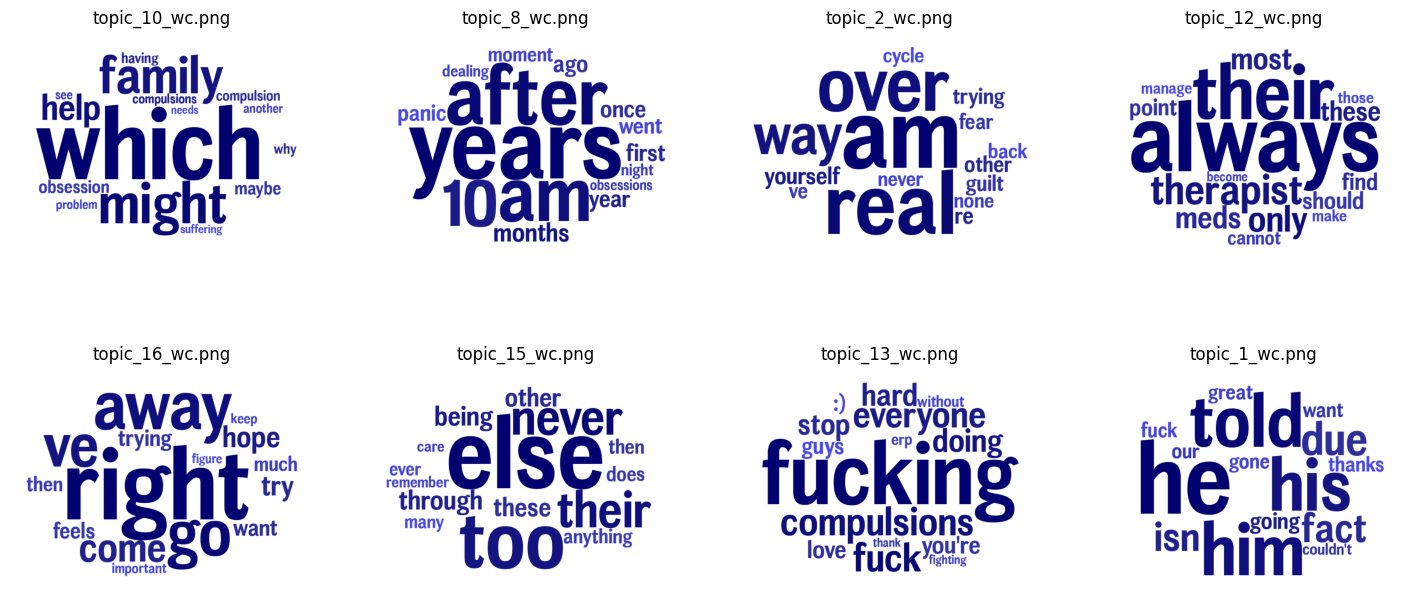

In [ ]:
WORDCLOUD_FOLDER = './output_tutorial_13/rd_ocd_all/topic_wordclouds_alltopics'
NUM_TOPICS = 8

print_topic_wordclouds(WORDCLOUD_FOLDER, NUM_TOPICS)

## ‼️ **Save your database and/or output files** ‼️

Let's save this new database into as a database file in your GDrive `sqlite_databases` folder!

In [ ]:
database = 'reddit'

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# copy the database file to your Drive
!cp -f "sqlite_data/{database}.db" "/content/drive/MyDrive/sqlite_databases/"

print(f"✅ Database '{database}.db' has been copied to your Google Drive.")

Now let's save the output (wordclouds and files) in this tutorial! Here's how you can save it to your Drive (if you want to)!

In [ ]:
OUTPUT_FOLDER = './output_tutorial_13'

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Copy the database file to your Drive (-r makes it copy the folder and all files/folders inside)
!cp -f -r {OUTPUT_FOLDER} "/content/drive/MyDrive/"

print(f"✅ '{OUTPUT_FOLDER}' has been copied to your Google Drive.")

FYI: The scraper also generated a `csv` of your data in your home directory. Check in the file tree (where you can download it) 😎